# Dirichlet model training

In this notebook we will train Dirichlet model for atrial fibrillation detection.

## Table of contents

* [Dataset initialization](#Dataset-initialization)
* [Training pipeline](#Training-pipeline)
* [Saving the model](#Saving-the-model)
* [Testing pipeline](#Testing-pipeline)
* [Predicting pipeline](#Predicting-pipeline)
* [Analyzing the uncertainty](#Analyzing-the-uncertainty)
* [Visualizing predictions](#Visualizing-predictions)
    * [Certain prediction](#Certain-prediction)
    * [Uncertain prediction](#Uncertain-prediction)

In [1]:
import os
import sys
from functools import partial

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

sys.path.append(os.path.join("..", "..", ".."))
import cardio.dataset as ds
from cardio import EcgDataset
from cardio.dataset import B, V, F
from cardio.models.dirichlet_model import DirichletModel, concatenate_ecg_batch
from cardio.models.metrics import f1_score, classification_report, confusion_matrix

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


Seaborn plotting parameters setting:

In [2]:
sns.set("talk")

By default, TensorFlow attempts to allocate almost the entire memory on all of the available GPUs. Executing this instruction makes only the GPU with id 0 visible for TensorFlow in this process.

In [3]:
#%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Dataset initialization

First, we need to specify paths to ECG signals and their labels:

In [3]:
SIGNALS_PATH = os.path.expanduser("~")+"/coding/cnn/datasets/training2017/"
SIGNALS_MASK = SIGNALS_PATH + "*.hea"
LABELS_PATH = SIGNALS_PATH + "REFERENCE.csv"

Now let's create an ECG dataset and perform a train/test split:

In [4]:
eds = EcgDataset(path=SIGNALS_MASK, no_ext=True, sort=True)
eds.cv_split(0.8)

## Training pipeline

Dirichlet model builder expects model config to contain input signals' shape and class names:

In [5]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)

model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "input_shape": F(lambda batch: batch.signal[0].shape[1:]),
    "class_names": F(lambda batch: batch.label_binarizer.classes_),
    "loss": None,
}

In [6]:
N_EPOCH = 1000
BATCH_SIZE = 256

Model training pipeline is composed of:
* model initialization with the config defined above
* data loading, preprocessing (e.g. flipping) and augmentation (e.g. resampling)
* train step execution

Let's create a template pipeline, then link it to our training dataset and run:

In [7]:
template_train_ppl = (
    ds.Pipeline()
      .init_model("dynamic", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("loss_history", init_on_each_run=list)
      .load(components=["signal", "meta"], fmt="wfdb")
      .load(components="target", fmt="csv", src=LABELS_PATH)
      .drop_labels(["~"])
      .rename_labels({"N": "NO", "O": "NO"})
      .flip_signals()
      .random_resample_signals("normal", loc=300, scale=10)
      .random_split_signals(2048, {"A": 9, "NO": 3})
      .binarize_labels()
      .train_model("dirichlet", make_data=concatenate_ecg_batch,
                   fetches="loss", save_to=V("loss_history"), mode="a")
      .run(batch_size=BATCH_SIZE, shuffle=True, drop_last=True, n_epochs=N_EPOCH, lazy=True)
)

train_ppl = (eds.train >> template_train_ppl).run()

Training loss is stored in "loss_history" pipeline variable. Let's take a look at its plot:

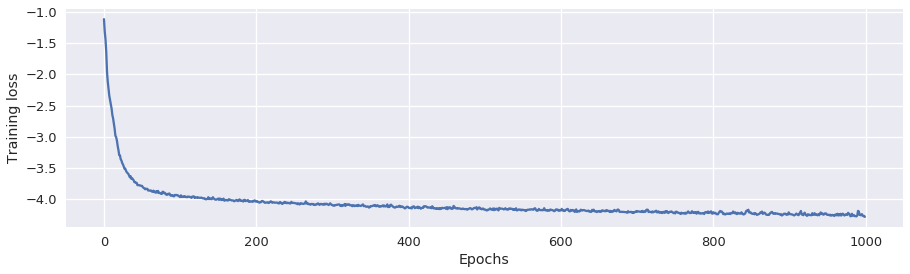

In [8]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss_history"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

As we can see, training loss almost reaches a plateau by the end of the training.

## Saving the model

In [10]:
#MODEL_PATH = "D:\\Projects\\data\\ecg\\dirichlet_model"
MODEL_PATH = os.path.expanduser("~")+"/coding/cnn/DeepECG/dirichlet_model"
train_ppl.save_model("dirichlet", path=MODEL_PATH)

## Testing pipeline

Testing pipeline is almost identical to the training one. The differences lie in the absence of signal resampling and the modified segmentation procedure. Notice, that the model is imported from the training pipeline, rather than being constructed from scratch.

In [11]:
template_test_ppl = (
    ds.Pipeline()
      .import_model("dirichlet", train_ppl)
      .init_variable("predictions_list", init_on_each_run=list)
      .load(components=["signal", "meta"], fmt="wfdb")
      .load(components="target", fmt="csv", src=LABELS_PATH)
      .drop_labels(["~"])
      .rename_labels({"N": "NO", "O": "NO"})
      .flip_signals()
      .split_signals(2048, 2048)
      .binarize_labels()
      .predict_model("dirichlet", make_data=concatenate_ecg_batch,
                     fetches="predictions", save_to=V("predictions_list"), mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

test_ppl = (eds.test >> template_test_ppl).run()

Now "predictions_list" pipeline variable stores model predictions and true targets for all signals labeled with "A", "O" and "N" in the testing dataset.

We will use [F1-score](https://en.wikipedia.org/wiki/F1_score) with macro averaging to measure classification performance:

In [12]:
predictions = test_ppl.get_variable("predictions_list")

In [13]:
f1_score(predictions)

0.89170797140566993

In [14]:
print(classification_report(predictions))

             precision    recall  f1-score   support

          A       0.84      0.77      0.80       171
         NO       0.97      0.98      0.98      1484

avg / total       0.96      0.96      0.96      1655



Also take a look at the more detailed report - the confusion matrix:

In [15]:
confusion_matrix(predictions)

True,A,NO,All
Pred,,,
A,132,25,157
NO,39,1459,1498
All,171,1484,1655


The model misclassifies 33 patients with atrial fibrillation and 25 patients with normal and other rhythms. All other patients were classified correctly.

We’ve already obtained good classification performance. Let’s see if we can do even better.

## Analyzing the uncertainty

In addition to class probabilities the model returns its uncertainty in the prediction, which varies from 0 (absolutely sure) to 1 (absolutely unsure). You can see the uncertainty histogram on the plot below:

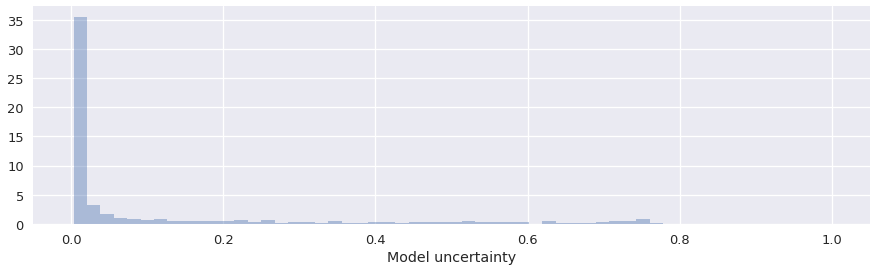

In [16]:
uncertainty = [d["uncertainty"] for d in predictions]

fig = plt.figure(figsize=(15, 4))
sns.distplot(uncertainty, hist=True, norm_hist=True, kde=False)
plt.xlabel("Model uncertainty")
plt.xlim(-0.05, 1.05)
plt.show()

The figure above shows, that the model is almost always certain in its predictions.

Compare the metrics for the full testing dataset above with the same metrics for 90% most certain predictions:

In [17]:
q = 90
thr = np.percentile(uncertainty, q)
certain_predictions = [d for d in predictions if d["uncertainty"] <= thr]

In [18]:
f1_score(certain_predictions)

0.94263368777931889

In [19]:
print(classification_report(certain_predictions))

             precision    recall  f1-score   support

          A       0.93      0.86      0.89       107
         NO       0.99      0.99      0.99      1382

avg / total       0.98      0.99      0.98      1489



In [20]:
confusion_matrix(certain_predictions)

True,A,NO,All
Pred,,,
A,92,7,99
NO,15,1375,1390
All,107,1382,1489


We can observe a significant increase in precision, recall and F1-score for the atrial fibrillation class. Now only 16 signals were misclassified.

## Predicting pipeline

Now let's predict class probabilities for a new, unobserved ECG signal.<br>
Besides, we will load pretrained model from MODEL_PATH directory instead of importing it from another pipeline:

In [21]:
# SIGNALS_PATH = "D:\\Projects\\data\\ecg\\training2017\\"
SIGNALS_PATH = os.path.expanduser("~")+"/coding/cnn/datasets/training2017/"
# MODEL_PATH = "D:\\Projects\\data\\ecg\\dirichlet_model"
MODEL_PATH = os.path.expanduser("~")+"/coding/cnn/DeepECG/dirichlet_model"

BATCH_SIZE = 100

In [22]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5, allow_growth=True)

model_config = {
    "session": {"config": tf.ConfigProto(gpu_options=gpu_options)},
    "build": False,
    "load": {"path": MODEL_PATH},
}

In [23]:
template_predict_ppl = (
    ds.Pipeline()
      .init_model("static", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("predictions_list", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "meta"])
      .flip_signals()
      .split_signals(2048, 2048)
      .predict_model("dirichlet", make_data=partial(concatenate_ecg_batch, return_targets=False),
                     fetches="predictions", save_to=V("predictions_list"), mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

INFO:tensorflow:Restoring parameters from /home/ubuntu/coding/cnn/DeepECG/dirichlet_model/model-26000


We need to create a dataset with a single ECG in it, then link it to the template predicting pipeline defined above and run it. Model prediction will be stored in the "predictions_list" variable.

In [24]:
signal_name = "A00001.hea"
signal_path = SIGNALS_PATH + signal_name
predict_eds = EcgDataset(path=signal_path, no_ext=True, sort=True)
predict_ppl = (predict_eds >> template_predict_ppl).run()

In [25]:
predict_ppl.get_variable("predictions_list")

[{'target_pred': {'A': 0.021257795, 'NO': 0.97874224},
  'uncertainty': 0.0075736045837402344}]

The length of the resulting list equals the length of the index of the dataset (1 in out case).

## Visualizing predictions

Now let's look at the target Dirichlet mixture density for a given signal. The pipeline below stores the signal and Dirichlet distribution parameters in its variables in addition to the predicted class probabilities.

In [26]:
template_full_predict_ppl = (
    ds.Pipeline()
      .init_model("static", DirichletModel, name="dirichlet", config=model_config)
      .init_variable("signals", init_on_each_run=list)
      .init_variable("predictions_list", init_on_each_run=list)
      .init_variable("parameters_list", init_on_each_run=list)
      .load(fmt="wfdb", components=["signal", "meta"])
      .update_variable("signals", value=B("signal"))
      .flip_signals()
      .split_signals(2048, 2048)
      .predict_model("dirichlet", make_data=partial(concatenate_ecg_batch, return_targets=False),
                     fetches=["predictions", "parameters"],
                     save_to=[V("predictions_list"), V("parameters_list")], mode="e")
      .run(batch_size=BATCH_SIZE, shuffle=False, drop_last=False, n_epochs=1, lazy=True)
)

INFO:tensorflow:Restoring parameters from /home/ubuntu/coding/cnn/DeepECG/dirichlet_model/model-26000


In [27]:
def predict_and_visualize(signal_path):
    predict_eds = EcgDataset(path=signal_path, no_ext=True, sort=True)
    
    full_predict_ppl = (predict_eds >> template_full_predict_ppl).run()
    signal = full_predict_ppl.get_variable("signals")[0][0][0][:2000].ravel()
    predictions = full_predict_ppl.get_variable("predictions_list")[0]
    parameters = full_predict_ppl.get_variable("parameters_list")[0]
    
    print(predictions)

    x = np.linspace(0.001, 0.999, 1000)
    y = np.zeros_like(x)
    for alpha in parameters:
        y += beta.pdf(x, *alpha)
    y /= len(parameters)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={"width_ratios": [2.5, 1]}, figsize=(15, 4))

    ax1.plot(signal)

    ax2.plot(x, y)
    ax2.fill_between(x, y, alpha=0.3)
    ax2.set_ylim(ymin=0)

    plt.show()

### Certain prediction

First, let’s look at the healthy person’s ECG. The signal is shown on the left plot. Note that it has a clear quasi periodic structure. The right plot shows the pdf of the mixture distributions with atrial fibrillation probability plotted on the horizontal axis. The model is absolutely certain in the absence of AF: almost all the probability density is concentrated around 0.

{'target_pred': {'A': 0.021271603, 'NO': 0.97872835}, 'uncertainty': 0.0074365139007568359}


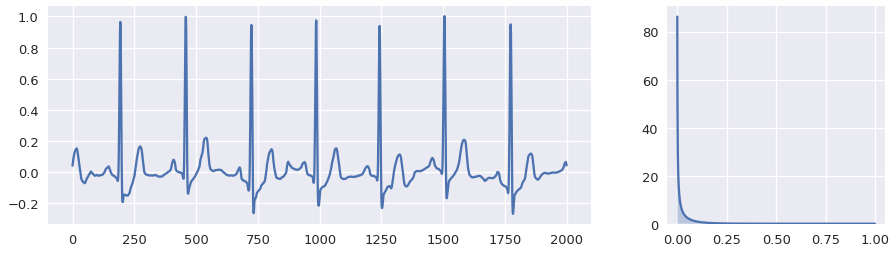

In [28]:
predict_and_visualize(SIGNALS_PATH + "A00150.hea")

### Uncertain prediction

And now comes an ECG with irregular structure, which may be caused by a disease or some measurement errors. The probability density on the right plot is almost equally concentrated around 0 and 1. This is an example of an uncertain prediction.

{'target_pred': {'A': 0.19596583, 'NO': 0.80403417}, 'uncertainty': 0.4200446605682373}


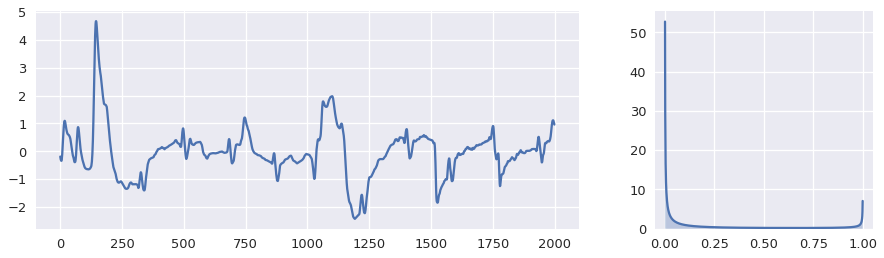

In [29]:
predict_and_visualize(SIGNALS_PATH + "A01505.hea")